In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import numpy as np
import re

sns.set_theme()

In [2]:
def get_metrics(
        logs_path,
        hist_stats_names=("policy_main_reward", "win_rate", "final_card_sum_0", "final_card_sum_1", "final_card_sum_2", "undesirable_action_0")
):
    files = [os.path.join(logs_path, f) for f in os.listdir(logs_path) if os.path.isfile(os.path.join(logs_path, f))]
    files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    hist_stats = defaultdict(list)
    for file in files:
        with open(file) as f:
            d = json.load(f)
            for hist_stat in hist_stats_names:
                if hist_stat not in d["env_runners"]["hist_stats"]:
                    continue
                hist_stats[hist_stat].append(np.array(d["env_runners"]["hist_stats"][hist_stat]))
                hist_stats[hist_stat+"_mean"].append(np.mean(hist_stats[hist_stat][-1]))
                hist_stats[hist_stat+"_min"].append(np.mean(hist_stats[hist_stat][-1]))
                hist_stats[hist_stat+"_max"].append(np.mean(hist_stats[hist_stat][-1]))

    return hist_stats

In [3]:
# Add all paths to the experiments here
logs_to_evaluate = [
    "logs/logs10",
    "logs/logs11",
    # "logs/logs12",
    "logs/logs13",
]

all_hist_stats = []
for log_path in logs_to_evaluate:
    all_hist_stats.append(get_metrics(log_path))

plt.rcParams["figure.figsize"] = (12, 8)

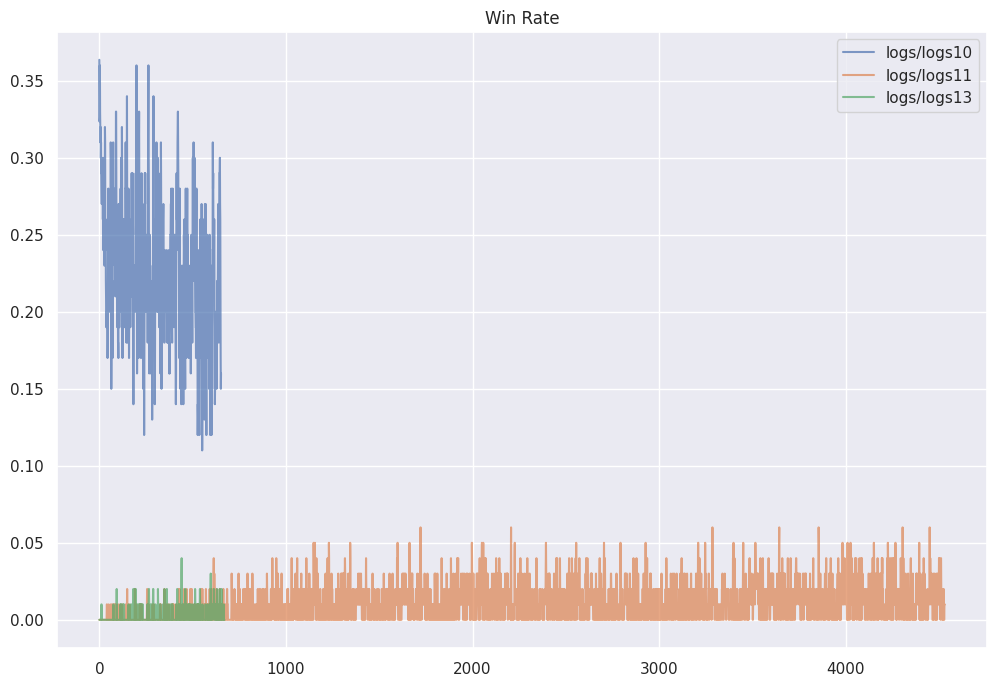

In [4]:
for logs, hist_stats in zip(logs_to_evaluate, all_hist_stats):
    sns.lineplot(hist_stats["win_rate_mean"], label=logs, alpha=0.7)
plt.title("Win Rate")
plt.legend()
plt.show()

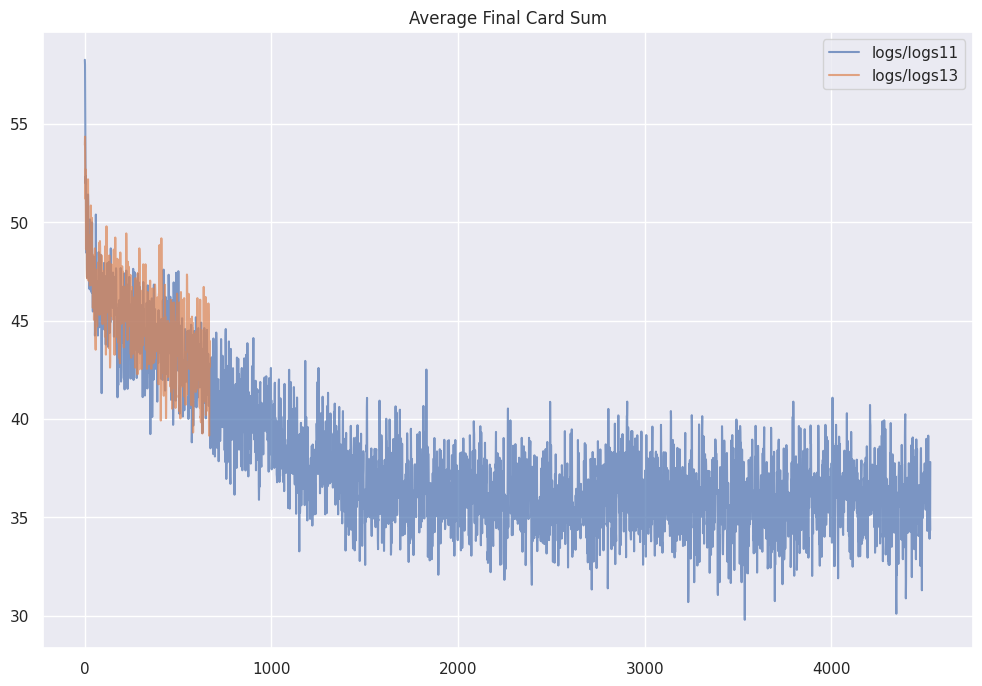

In [5]:
for logs, hist_stats in zip(logs_to_evaluate, all_hist_stats):
    sns.lineplot(hist_stats["final_card_sum_0_mean"], label=logs, alpha=0.7)
plt.title("Average Final Card Sum")
plt.legend()
plt.show()

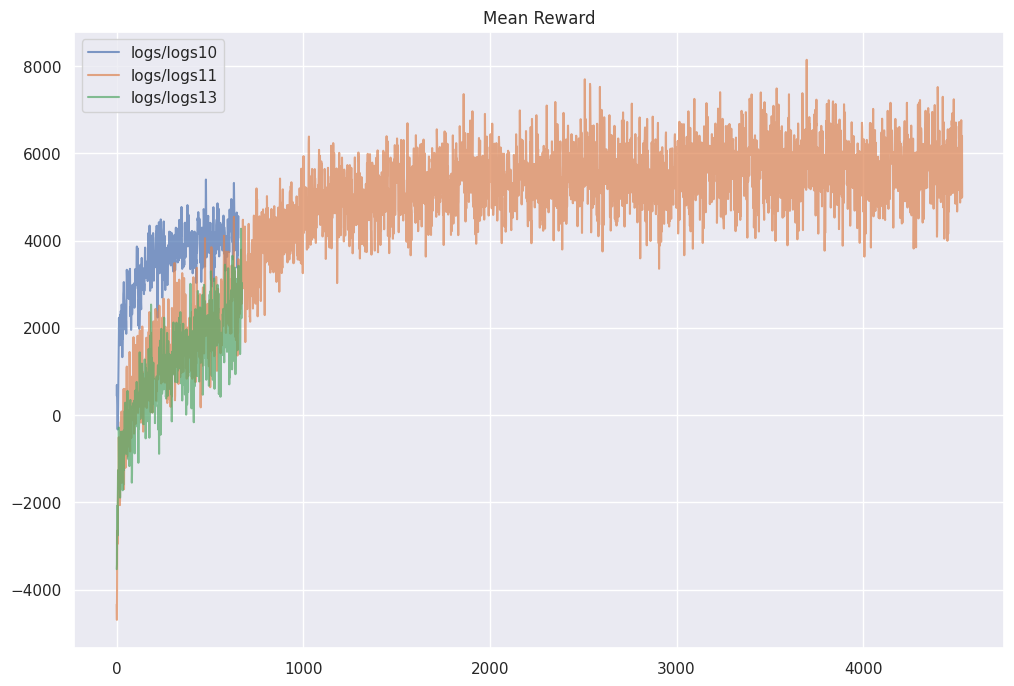

In [6]:
for logs, hist_stats in zip(logs_to_evaluate, all_hist_stats):
    sns.lineplot(hist_stats["policy_main_reward_mean"], label=logs, alpha=0.7)
plt.title("Mean Reward")
plt.legend()
plt.show()

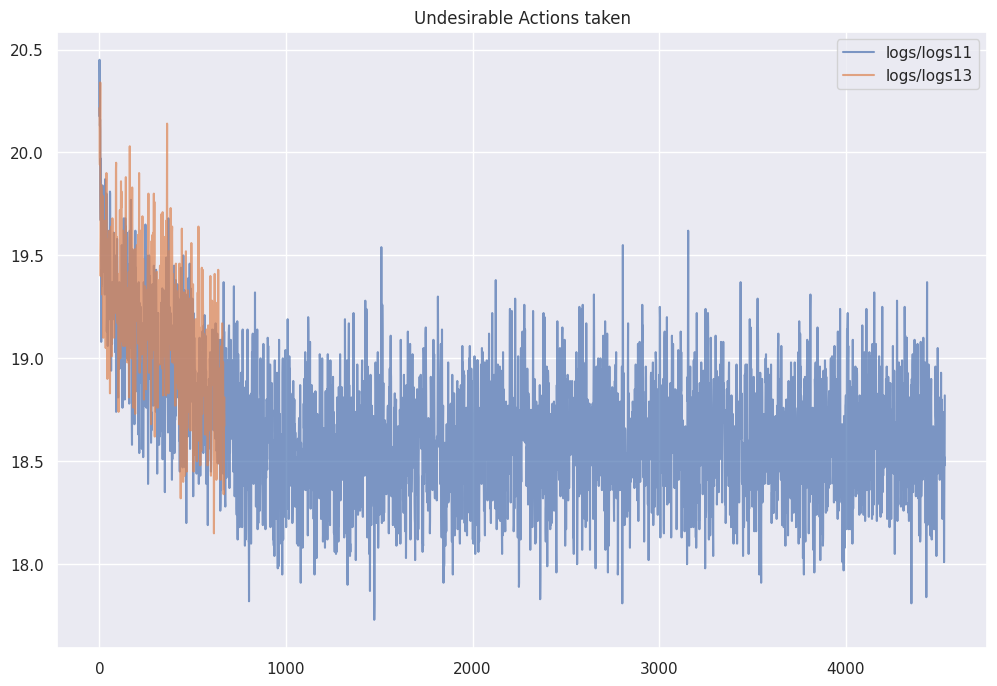

In [7]:
plt.show()
for logs, hist_stats in zip(logs_to_evaluate, all_hist_stats):
    sns.lineplot(hist_stats["undesirable_action_0_mean"], label=logs, alpha=0.7)
plt.title("Undesirable Actions taken")
plt.legend()
plt.show()